# Lale: Types and Auto-ML for Scikit-learn

```
TODO
- value proposition
- target audience
- motivation
- terminology: operator
- available operators with schemas
- soap-box: single source of truth
- tl;dr
- link to installation instruction
```

### Types as Documentation

In [1]:
import lale.lib.sklearn
from lale.pretty_print import ipython_display
ipython_display(lale.lib.sklearn.DecisionTreeRegressor.hyperparam_schema('criterion'))

```python
{
    'enum': ['mse', 'friedman_mse', 'mae'],
    'default': 'mse',
    'description': 'The function to measure the quality of a split. Supported criteria'}
```

In [2]:
ipython_display(lale.lib.sklearn.DecisionTreeRegressor.hyperparam_schema('max_depth'))

```python
{
    'description': 'The maximum depth of the tree.',
    'anyOf': [
    {   'type': 'integer',
        'minimumForOptimizer': 3,
        'maximumForOptimizer': 5},
    {   'description': 'Nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.',
        'enum': [null]}],
    'default': null}
```

In [3]:
ipython_display(lale.lib.sklearn.DecisionTreeRegressor.hyperparam_defaults())

```python
{
    'criterion': 'mse',
    'splitter': 'best',
    'max_depth': null,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': null,
    'random_state': null,
    'max_leaf_nodes': null,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': null,
    'presort': false}
```

In [4]:
ipython_display(lale.lib.sklearn.NMF.input_schema_fit())

```python
{
    'type': 'object',
    'required': ['X'],
    'additionalProperties': false,
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number',
                    'minimum': 0.0}}},
        'y': {}}}
```

### Hyperparameter Error Example in Scikit-Learn

In [5]:
import sys
import sklearn
from sklearn import pipeline, feature_selection, ensemble, tree

In [6]:
sklearn_hyperparam_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.tree.DecisionTreeRegressor(max_depth=-1))

In [7]:
import pandas as pd
import lale.datasets as ds
(train_X, train_y), (test_X, test_y) = ds.california_housing_df()
schema_X = ds.data_schemas.to_schema(train_X)
schema_y = ds.data_schemas.to_schema(train_y)
pd.concat([train_X.head(5), train_y.head(5)], axis=1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


In [8]:
%%time
try:
    sklearn_hyperparam_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 4.08 s, sys: 109 ms, total: 4.19 s
Wall time: 4.21 s


max_depth must be greater than zero. 


In [9]:
assert message.startswith("max_depth must be greater than zero.")

### Types for Hyperparameter Checking

In [10]:
import lale.operators
import jsonschema

In [11]:
%%time
try:
    lale_hyperparam_error = lale.operators.make_pipeline(
        lale.lib.sklearn.RFE(
            estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
        lale.lib.sklearn.DecisionTreeRegressor(max_depth=-1))
except jsonschema.ValidationError as e:
    message = e.message
print(message, file=sys.stderr)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 31.1 ms


max_depth must be greater than zero. 


In [12]:
assert message.startswith("max_depth must be greater than zero.")

### Dataset Error Example in Scikit-Learn

In [13]:
from sklearn import decomposition

In [14]:
sklearn_dataset_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.decomposition.NMF())

In [15]:
%%time
try:
    sklearn_dataset_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 4.12 s, sys: 125 ms, total: 4.25 s
Wall time: 4.26 s


Negative values in data passed to NMF (input X)


In [16]:
assert message.startswith("Negative values in data passed to NMF (input X)")

### Types for Dataset Checking

In [17]:
lale_dataset_error = lale.operators.make_pipeline(
    lale.lib.sklearn.RFE(
        estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
    lale.lib.sklearn.NMF())

In [18]:
%%time
try:
    lale_dataset_error.validate_schema(schema_X, schema_y)
except lale.helpers.SubschemaError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 113 ms


Expected to_schema(data) to be a subschema of NMF.input_schema_fit().
to_schema(data) = {
    'type': 'object',
    'additionalProperties': false,
    'required': ['X', 'y'],
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number'}}},
        'y': {
            'type': 'array',
            'minItems': 16512,
            'maxItems': 16512,
            'items': {
                'description': 'target',
                'type': 'number'}}}}
NMF.input_schema_fit() = {
    'type': 'object',
    'required': ['X'],
    'additionalProperties': false,
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number',
                    'minimum': 0.0}}},
        'y': {}}}


In [19]:
assert message.startswith('Expected to_schema(data) to be a subschema of NMF.input_schema_fit().')

### Types for Hyperparameter Tuning

In [20]:
from sklearn.decomposition import PCA
from lale.lib.sklearn import DecisionTreeRegressor as Tree
import lale.helpers
lale.helpers.wrap_imported_operators()

In [21]:
pca_tree_planned = lale.operators.make_pipeline(PCA, Tree)

In [22]:
from lale.lib.lale import HyperoptRegressor
pca_tree_hyperopt = HyperoptRegressor(pca_tree_planned, cv=3, max_evals=10)
pca_tree_trained = pca_tree_hyperopt.fit(train_X, train_y)

100%|██████████| 10/10 [00:07<00:00,  1.96it/s, best loss: -0.4592055589020749]


In [23]:
predicted = pca_tree_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.40


### Non-Linear Pipelines

In [24]:
from lale.lib.lale import NoOp
from sklearn.feature_selection import RFE
from lale.lib.lale import ConcatFeatures as HStack
from sklearn.linear_model import LinearRegression as LinReg
from xgboost import XGBRegressor as XGBoost
lale.helpers.wrap_imported_operators()

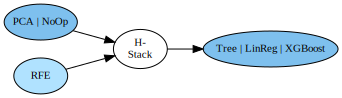

In [25]:
dag_without_combinators = lale.operators.make_pipeline(
    lale.operators.make_union(
        lale.operators.make_choice(PCA, NoOp),
        RFE(estimator=XGBoost(n_estimators=10))),
    lale.operators.make_choice(Tree, LinReg, XGBoost))
lale.helpers.to_graphviz(dag_without_combinators)

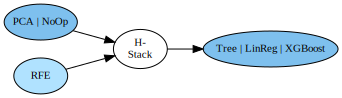

In [26]:
dag_with_combinators = (
        (PCA | NoOp)
      & RFE(estimator=XGBoost(n_estimators=10))
    ) >> HStack >> (Tree | LinReg | XGBoost)
lale.helpers.to_graphviz(dag_with_combinators)

### Combined Algorithm Selection and Hyperparameter Optimization

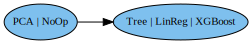

In [27]:
multi_alg_planned = (PCA | NoOp) >> (Tree | LinReg | XGBoost)
lale.helpers.to_graphviz(multi_alg_planned)

In [28]:
multi_alg_hyperopt = HyperoptRegressor(estimator=multi_alg_planned, cv=3, max_evals=10)
multi_alg_trained = multi_alg_hyperopt.fit(train_X, train_y)

100%|██████████| 10/10 [00:45<00:00,  4.39s/it, best loss: -0.7101352497539155]


In [29]:
predicted = multi_alg_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.71


### Inspecting the Results of Automation

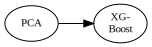

In [30]:
lale.helpers.to_graphviz(multi_alg_trained._impl)

In [31]:
ipython_display(multi_alg_trained._impl, show_imports=False)

```python
pca = PCA(svd_solver='arpack', whiten=True)
xgboost = XGBoost(colsample_bylevel=0.8125953277265251, colsample_bytree=0.7432005864418613, learning_rate=0.336632702036662, max_depth=4, min_child_weight=8, n_estimators=1012, reg_alpha=0.02223895190558911, reg_lambda=0.02984096814184546, subsample=0.498939586636504)
pipeline = pca >> xgboost
```

### Hyperparameter Constraint Example in Scikit-Learn

In [32]:
sklearn_constraint_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.decomposition.PCA(svd_solver='arpack', n_components='mle'))

In [33]:
%%time
message=None
try:
    sklearn_constraint_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 4.5 s, sys: 125 ms, total: 4.62 s
Wall time: 4.67 s


n_components='mle' cannot be a string with svd_solver='arpack'


In [34]:
assert message.startswith("n_components='mle' cannot be a string with svd_solver='arpack'")

### Types for Constraint Checking

In [35]:
%%time
try:
    lale_constraint_error = lale.operators.make_pipeline(
        lale.lib.sklearn.RFE(
            estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
        PCA(PCA.svd_solver.arpack, PCA.n_components.mle))
except jsonschema.ValidationError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 57.5 ms


Invalid configuration for PCA(svd_solver='arpack', n_components='mle') due to constraint option n_components mle can be set for svd_solver full or auto.
Schema of constraint 1: {
    'description': 'Option n_components mle can be set for svd_solver full or auto.',
    'anyOf': [
    {   'type': 'object',
        'properties': {
            'n_components': {
                'not': {
                    'enum': ['mle']}}}},
    {   'type': 'object',
        'properties': {
            'svd_solver': {
                'enum': ['full', 'auto']}}}]}
Value: {'svd_solver': 'arpack', 'n_components': 'mle', 'copy': True, 'whiten': False, 'tol': 0.0, 'iterated_power': 'auto', 'random_state': None}


In [36]:
assert message.startswith("Invalid configuration for PCA(svd_solver='arpack', n_components='mle')")

### FAQ

```
TODO
- can I change the metric used in optimization
- can I implement other tasks besides regression
- how about other modalities besides tables
- this operator gives me an error
- can I tweak the schemas of an operator
- the operator I need is missing
- how does search space generation work
- does Lale optimize for computational performance
```